In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); assert osp.exists(scripts_folder)
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'; assert osp.exists(ffmpeg_folder)
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)

if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)

# Import needed libraries
import re
import pandas as pd
import pyperclip
import ipywidgets as widgets
from IPython.display import display

Pretty printing has been turned OFF


In [22]:

print([f'osp.{fn}' for fn in dir(osp) if ('base' in fn)])

['osp.basename']



#### Breaking Up `notebook_utils.py`

I have a solid plan for refactoring your `notebook_utils.py` file, which is quite lengthy at 5,646 lines. Here’s my structured approach to help with the process:

**1. Analyzing the Structure:**
   - I already have clear sections marked by comments, which is a great starting point. Each section can potentially correspond to a separate module or file.
   - The sections are:
     - Numeric Functions
     - String Functions
     - List Functions
     - File Functions
     - Path Functions
     - Storage Functions
     - Module Functions
     - URL and Soup Functions
     - Pandas Functions
     - 3D Point Functions
     - Sub-sampling Functions
     - Plotting Functions

In [37]:

from pandas import DataFrame

# Categorize the odd-splitted functions by their previous even-splitted comment
section_regex = re.compile("^    ### ([A-Za-z0-9 -]+) ###", re.MULTILINE)
file_path = "../share/notebook_utils.py" 
with open(file_path, "r") as f:
    data = f.read()

sections = section_regex.split(data)
headers_list = []
for i in range(1, len(sections), 2):
    headers_list.append(sections[i])
rows_list = []
for header, i in zip(headers_list, range(2, len(sections), 2)):
    print(header)
    for function_str in nu.simple_defs_regex.findall(sections[i]):
        row_dict = {
            'function': function_str,
            'header': header
        }
        rows_list.append(row_dict)
if nu.pickle_exists('notebook_utils_funcs_df'):
    notebook_utils_funcs_df = nu.load_object('notebook_utils_funcs_df')
else:
    notebook_utils_funcs_df = DataFrame(rows_list)
    nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

Numeric Functions
String Functions
List Functions
File Functions
Path Functions
Storage Functions
Module Functions
URL and Soup Functions
Pandas Functions
3D Point Functions
Sub-sampling Functions
Plotting Functions



**2. Creating a Dependency Graph:**
   - Using `networkx`, I will create a graph where nodes represent functions and import statements, and edges represent dependencies (e.g., a function using an import or calling another function).
   - This graph will help visualize how functions are interconnected, which is crucial for determining which functions should reside in the same file.

**3. Applying Girvan-Newman Algorithm:**
   - The Girvan-Newman algorithm is effective for detecting communities within a graph. In my case, it can help identify clusters of functions that are closely related based on their dependencies.
   - Each community can then be translated into a separate file, ensuring that related functions and their dependencies are kept together.

**4. Implementation Steps:**
   - **Step 1:** Parse `notebook_utils.py` to extract function definitions and their dependencies.
   - **Step 2:** Construct the dependency graph using `networkx`.
   - **Step 3:** Apply the Girvan-Newman algorithm to find communities.
   - **Step 4:** Create new Python files for each community, ensuring to maintain the necessary import statements.

**5. Refactoring Considerations:**
   - I will ensure that each new file has a clear purpose and that the functions within are logically grouped.
   - I will use naming conventions for the new files to reflect their contents (e.g., `numeric_functions.py`, `string_functions.py`, etc.).
   - After refactoring, I willthoroughly test the new structure to ensure that all functionalities remain intact.

This approach not only organizes my code better but also enhances maintainability and readability, making it easier for me and others to work with in the future.


To create the `networkx` graph that represents the dependencies in my `notebook_utils.py` file, I need to parse the file to extract the following:

1. **Functions**: Each function defined in the file.
2. **Imports**: External libraries/modules imported in the file.
3. **Function Dependencies**: Relationships where:
   - A function calls another function within the file.
   - A function uses an imported module or library.
   - A function references `self` (if it's part of a class).

Once I have this data, I can construct the graph where:
- **Nodes** represent functions, imports, and `self` references.
- **Edges** represent dependencies (e.g., Function A calls Function B, or Function A uses an import).

Here’s my step-by-step guide to implementing this process with `networkx`:

---

### Step 1: Parse `notebook_utils.py`

I will use Python's `ast` module to parse the file and extract function definitions, imports, and function calls.

In [12]:

import ast
import networkx as nx

def parse_python_file(file_path):
    """
    Parse the Python file to extract functions, imports, and dependencies.

    Args:
        file_path (str): Path to the Python file.

    Returns:
        dict: A dictionary containing:
            - functions (list): List of function names.
            - imports (list): List of imported modules.
            - dependencies (dict): Mapping of function names to their dependencies.
    """
    with open(file_path, "r") as file:
        tree = ast.parse(file.read())

    functions = []
    imports = []
    dependencies = {}

    # Traverse the AST
    for node in ast.walk(tree):
        # Collect function definitions
        if isinstance(node, ast.FunctionDef):
            func_name = node.name
            functions.append(func_name)
            dependencies[func_name] = []

            # Check for function calls within the body of the function
            for child in ast.walk(node):
                if isinstance(child, ast.Call):
                    # If the call is to another function, add it as a dependency
                    if isinstance(child.func, ast.Name):
                        dependencies[func_name].append(child.func.id)
                    # If the call is to a method (e.g., self.method), capture it
                    elif isinstance(child.func, ast.Attribute):
                        dependencies[func_name].append(child.func.attr)

        # Collect import statements
        elif isinstance(node, ast.Import):
            for alias in node.names:
                imports.append(alias.name)
        elif isinstance(node, ast.ImportFrom):
            module = node.module
            for alias in node.names:
                imports.append(f"{module}.{alias.name}" if module else alias.name)

    return {
        "functions": functions,
        "imports": imports,
        "dependencies": dependencies,
    }


---

### Step 2: Build the `networkx` Graph

Once I have the parsed data (functions, imports, dependencies), I can build a directed graph in `networkx`.

In [13]:

def build_dependency_graph(parsed_data):
    """
    Build a NetworkX graph from the parsed data.

    Args:
        parsed_data (dict): Output from the parse_python_file function.

    Returns:
        networkx.DiGraph: A directed graph representing the dependencies.
    """
    G = nx.DiGraph()

    # Add nodes for functions and imports
    for func in parsed_data["functions"]:
        G.add_node(func, type="function")
    for imp in parsed_data["imports"]:
        G.add_node(imp, type="import")

    # Add edges for dependencies
    for func, deps in parsed_data["dependencies"].items():
        for dep in deps:
            # Only add an edge if the dependency exists as a node
            if dep in G.nodes:
                G.add_edge(func, dep)

    return G


---

### Step 3: Apply the Girvan-Newman Algorithm

The Girvan-Newman algorithm finds communities (clusters) in a graph by progressively removing edges with the highest betweenness centrality. Each cluster represents a group of closely related nodes.

In [14]:

from networkx.algorithms.community import girvan_newman

def find_communities(G):
    """
    Apply the Girvan-Newman algorithm to find communities in the graph.

    Args:
        G (networkx.DiGraph): The dependency graph.

    Returns:
        list of sets: A list of sets, where each set is a community of nodes.
    """
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)  # First split
    return [set(community_list) for community_list in top_level_communities]


---

### Step 4: Visualize the Graph (Optional)

If you want to visualize the dependency graph, you can use `matplotlib` with `networkx`.

In [15]:

import matplotlib.pyplot as plt

def visualize_graph(G):
    """
    Visualize the dependency graph using matplotlib.

    Args:
        G (networkx.DiGraph): The dependency graph.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle="->")
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    plt.title("Dependency Graph")
    plt.show()


---

### Step 5: Refactor Based on Communities

Once I identify communities, I can refactor your code by:
1. Creating a new Python file for each community.
2. Moving the corresponding functions and imports into those files.
3. Ensuring that cross-module dependencies are handled by importing the required functions.

In [17]:

# Find all the notebooks in the repository directory
pushables_list = nu.load_object('pushables_list')
black_list = ['.ipynb_checkpoints', '$Recycle.Bin']
file_ending = '.ipynb'
file_paths_list = []
for root_dir in pushables_list:
    for parent_directory, child_directories, files_list in os.walk(root_dir):
        if all(map(lambda x: x not in parent_directory, black_list)):
            for old_file_name in files_list:
                if old_file_name.endswith(file_ending):
                    old_file_path = os.path.join(parent_directory, old_file_name)
                    file_paths_list.append(old_file_path)

In [18]:

# Regular expression to match `nu.<function_name>`
nu_call_regex = re.compile(r'\bnu\.([a-zA-Z_][a-zA-Z0-9_]*)')

# Find all the notebooks that employ notebook_utils methods
notebook_paths_list = []
for notebook_path in file_paths_list:
    with open(notebook_path, 'r', encoding=nu.encoding_type) as f:
        data = f.read()
        if nu_call_regex.search(data):
            notebook_paths_list.append(notebook_path)

In [19]:

def extract_notebook_usage_notebook_utils(notebook_path):
    """
    Extract function calls to `nu.<function>` from a Jupyter Notebook.

    Args:
        notebook_path (str): Path to the Jupyter Notebook (.ipynb) file.

    Returns:
        list: A list of function names called from `nu` (e.g., ['foo', 'bar']).
    """
    
    function_calls = []
    with open(notebook_path, 'r') as file:
        try:
            notebook = json.load(file)
            
            # Look for code cells in the notebook
            for cell in notebook.get('cells', []):
                if cell.get('cell_type') == 'code':
                    source = ''.join(cell.get('source', []))  # Combine source lines
                    function_calls.extend(nu_call_regex.findall(source))
        
        except UnicodeDecodeError as e:
            print(f'{e.__class__.__name__} error trying to load {notebook_path}: {e}')
    
    return function_calls

In [110]:

JUNK_NODES = ['Installs', 'OS Path Navigation', 'Scratchpad', 'Attic']
def augment_graph_with_nu_calls(G, notebook_paths):
    """
    Augment the dependency graph with real-world usage of `nu.<function>` from Jupyter Notebooks.

    Args:
        G (networkx.DiGraph): The initial dependency graph.
        notebooks_dir (str): Path to the directory containing Jupyter Notebooks.
    """

    for notebook_path in notebook_paths:
        notebook_name = osp.basename(notebook_path).split('.')[0]  # Use the notebook filename as a node
        if notebook_name not in JUNK_NODES:
            G.add_node(notebook_name, type="notebook")
            
            # Extract `nu.<function>` calls
            nu_calls = extract_notebook_usage_notebook_utils(notebook_path)
            
            # Add edges for function calls
            for func in nu_calls:
                if func in G.nodes:  # Only add edges to functions that exist in the graph
                    G.add_edge(notebook_name, func)

In [22]:

def find_communities_with_limit(G, max_communities=10, verbose=False):
    """
    Use the Girvan-Newman algorithm to find a limited number of communities.

    Args:
        G (networkx.DiGraph): The dependency graph.
        max_communities (int): Desired number of communities.

    Returns:
        list of sets: A list of sets, where each set is a community of nodes.
    """
    from networkx.algorithms.community import girvan_newman

    # Generator for progressively finer communities
    communities_generator = girvan_newman(G)
    
    # Start with the entire graph as one community
    current_communities = [set(G.nodes())]
    print(len(current_communities))
    
    # Iterate through splits until we reach the desired number of communities
    for communities in communities_generator:
        current_communities = [set(c) for c in communities]
        print(len(current_communities))
        if len(current_communities) >= max_communities:
            break
    
    return current_communities

In [115]:

import community  # python-louvain library

def find_communities_louvain(G):
    """
    Use the Louvain algorithm to find communities.

    Args:
        G (networkx.DiGraph): The dependency graph.

    Returns:
        dict: A dictionary mapping nodes to community IDs.
    """
    
    # Louvain algorithm for modularity-based clustering
    partition = community.best_partition(G.to_undirected())
    
    return partition

In [24]:

def find_connected_components(G):
    """
    Find connected components of the graph.

    Args:
        G (networkx.DiGraph): The dependency graph.

    Returns:
        list of sets: A list of node sets, where each set is a connected component.
    """
    
    # Get connected components (ignoring edge direction)
    components = list(nx.connected_components(G.to_undirected()))
    
    return components

In [124]:

from itertools import combinations, chain
from collections import defaultdict

def market_basket_analysis(notebook_paths_list, dependency_graph):
    """
    Perform market basket analysis using notebooks as baskets and connected nodes as items.

    Args:
        notebook_paths_list (list): A list of notebook paths.
        dependency_graph (networkx.Graph): A NetworkX graph where nodes represent items.

    Returns:
        dict: A dictionary containing support, confidence, and lift for item associations.
    """
    # Step 1: Prepare baskets
    baskets = {}
    for notebook_path in notebook_paths_list:
        notebook_name = osp.basename(notebook_path).split('.')[0]
        if notebook_name not in JUNK_NODES:
            connected_nodes = set(dependency_graph.neighbors(notebook_name))
            baskets[notebook_name] = connected_nodes

    # Step 2: Calculate support for single items and item-pairs
    item_support = defaultdict(int)
    pair_support = defaultdict(int)
    total_baskets = len(baskets)

    # Count occurrences of individual items and pairs
    for basket_items in baskets.values():
        for item in basket_items:
            item_support[item] += 1
        for item_pair in combinations(basket_items, 2):
            pair_support[frozenset(item_pair)] += 1

    # Calculate support (as a fraction of total baskets)
    item_support = {item: count / total_baskets for item, count in item_support.items()}
    pair_support = {pair: count / total_baskets for pair, count in pair_support.items()}

    # Step 3: Calculate confidence and lift for item pairs
    analysis = {}
    for pair, pair_sup in pair_support.items():
        item_a, item_b = tuple(pair)
        conf_a_to_b = pair_sup / item_support[item_a]
        conf_b_to_a = pair_sup / item_support[item_b]
        lift = pair_sup / (item_support[item_a] * item_support[item_b])

        analysis[pair] = {
            "support": pair_sup,
            "confidence_a_to_b": conf_a_to_b,
            "confidence_b_to_a": conf_b_to_a,
            "lift": lift,
        }

    return analysis

In [67]:

def convert_to_dataframe(result):
    """
    Convert the market basket analysis result into a Pandas DataFrame for easy display.

    Args:
        result (dict): A dictionary containing item-pairs as keys and their metrics (support, confidence, lift) as values.

    Returns:
        pandas.DataFrame: A DataFrame with columns for item-pairs, support, confidence, and lift.
    """
    # Prepare rows for the DataFrame
    rows = []
    for pair, metrics in result.items():
        rows.append({
            "Function A": list(pair)[0],  # Extract the first item in the pair
            "Function B": list(pair)[1],  # Extract the second item in the pair
            "Support (P(A ∩ B))": metrics["support"],
            "Confidence (A -> B)": metrics["confidence_a_to_b"],
            "Confidence (B -> A)": metrics["confidence_b_to_a"],
            "Lift": metrics["lift"]
        })

    # Create the DataFrame
    df = DataFrame(rows)

    # Sort by Support for better readability (optional)
    df = df.sort_values(by="Support (P(A ∩ B))", ascending=False).reset_index(drop=True)

    return df

In [85]:

import itertools

def get_girvan_newman_node_colors(directed_graph):
    
    # Step 2: Convert the directed graph into an undirected graph for community detection
    undirected_graph = directed_graph.to_undirected()
    
    # Step 3: Apply the Girvan-Newman algorithm to detect communities
    communities = girvan_newman(undirected_graph)
    
    # Get the first level of communities (split into two groups initially)
    top_level_communities = next(communities)
    community_list = [list(community_set) for community_set in top_level_communities]
    
    # Step 4: Assign a color to each community
    # Create a mapping of nodes to colors based on community membership
    color_map = {}
    colors = itertools.cycle(["red", "blue", "green", "orange", "purple", "cyan"])  # Define some colors
    community_colors = {i: next(colors) for i in range(len(community_list))}
    
    for community_id, community_nodes in enumerate(community_list):
        for node in community_nodes:
            color_map[node] = community_colors[community_id]
    
    # Create a list of node colors for visualization
    node_colors = [color_map[node] for node in undirected_graph.nodes()]
    
    return node_colors, community_list

In [111]:

# Parse the file
parsed_data = parse_python_file("../share/notebook_utils.py")

# Build the graph
dependency_graph = build_dependency_graph(parsed_data)

In [112]:

# Augment the graph with notebook usage
augment_graph_with_nu_calls(dependency_graph, notebook_paths_list)

UnicodeDecodeError error trying to load C:\Users\daveb\OneDrive\Documents\GitHub\dave-babbitt-technical-assessment\ipynb\Data Augmentation Using LLMs.ipynb: 'charmap' codec can't decode byte 0x81 in position 34814: character maps to <undefined>
UnicodeDecodeError error trying to load C:\Users\daveb\OneDrive\Documents\GitHub\itm-analysis-reporting-1\builders\Build a Model to Predict Entities from Domain Documents.ipynb: 'charmap' codec can't decode byte 0x9d in position 97647: character maps to <undefined>
UnicodeDecodeError error trying to load C:\Users\daveb\OneDrive\Documents\GitHub\itm-analysis-reporting-1\builders\Parse Domain Documents for Entities.ipynb: 'charmap' codec can't decode byte 0x9d in position 19360: character maps to <undefined>
UnicodeDecodeError error trying to load C:\Users\daveb\OneDrive\Documents\GitHub\itm-analysis-reporting-1\explorations\Analyze Issue with Logging Multiple TOOL_APPLIEDs.ipynb: 'charmap' codec can't decode byte 0x9d in position 53625: character

In [113]:

# Find connected components
components = find_connected_components(dependency_graph)

# Add the components to the data frame
for i, component in enumerate(components):
    mask_series = notebook_utils_funcs_df.function.isin(list(component))
    notebook_utils_funcs_df.loc[mask_series, 'connected_components'] = i
nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

In [116]:

# Re-run community detection
partition = find_communities_louvain(dependency_graph)  # Using Louvain for modularity-based clustering

# Group nodes by community ID
from collections import defaultdict
grouped_communities = defaultdict(list)
for node, community_id in partition.items():
    grouped_communities[community_id].append(node)

# Add the new communities to the data frame
for i, community_nodes in enumerate(grouped_communities.values()):
    mask_series = notebook_utils_funcs_df.function.isin(community_nodes)
    notebook_utils_funcs_df.loc[mask_series, 'louvain_partition'] = i
nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

In [117]:

# Find communities with a maximum of 10 groups
communities = find_communities_with_limit(dependency_graph, max_communities=10, verbose=True)

# Add the communities to the data frame
for i, community_set in enumerate(communities):
    mask_series = notebook_utils_funcs_df.function.isin(list(community_set))
    notebook_utils_funcs_df.loc[mask_series, 'girvan_newman_max10'] = i
nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

1
141


In [118]:

# Find communities
communities = find_communities(dependency_graph)

# Add the communities to the data frame
for i, community_set in enumerate(communities):
    mask_series = notebook_utils_funcs_df.function.isin(list(community_set))
    notebook_utils_funcs_df.loc[mask_series, 'girvan_newman'] = i
nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

In [119]:

for cn in ['connected_components', 'louvain_partition', 'girvan_newman_max10', 'girvan_newman']:
    notebook_utils_funcs_df[cn] = notebook_utils_funcs_df[cn].astype(int)
nu.store_objects(notebook_utils_funcs_df=notebook_utils_funcs_df, verbose=False)

In [120]:

for header, df in notebook_utils_funcs_df.groupby('header'):
    print()
    print(header)
    for cn in ['connected_components', 'louvain_partition', 'girvan_newman']:
        print(cn + ':', sorted(df[cn].unique()))


3D Point Functions
connected_components: [2]
louvain_partition: [7, 24]
girvan_newman: [2]

File Functions
connected_components: [2, 3, 4]
louvain_partition: [2, 5, 9, 10, 11]
girvan_newman: [2, 3, 4, 5]

List Functions
connected_components: [2]
louvain_partition: [2, 4, 5, 6, 7, 8]
girvan_newman: [2]

Module Functions
connected_components: [2, 15, 16]
louvain_partition: [3, 5, 10, 22, 23]
girvan_newman: [2, 4, 16, 17]

Numeric Functions
connected_components: [1]
louvain_partition: [1]
girvan_newman: [1]

Pandas Functions
connected_components: [2, 17, 18, 19, 20, 21]
louvain_partition: [2, 4, 7, 24, 25, 26, 27, 28, 29]
girvan_newman: [2, 18, 19, 20, 21, 22]

Path Functions
connected_components: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
louvain_partition: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
girvan_newman: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Plotting Functions
connected_components: [2, 22, 23, 24]
louvain_partition: [3, 5, 6, 7, 8, 30, 31, 32]
girvan_newman: [2, 23, 24, 25]

Storage Fu

In [121]:

import random

list(random.choice(communities))

['scipy.optimize.curve_fit']

In [125]:

result = market_basket_analysis(notebook_paths_list, dependency_graph)
df = convert_to_dataframe(result)
display(df.head(20))

,Function A,Function B,Support (P(A ∩ B)),Confidence (A -> B),Confidence (B -> A),Lift
0,load_object,store_objects,0.284047,0.561538,0.752577,1.487787
1,pickle_exists,load_object,0.276265,0.986111,0.546154,1.949466
2,pickle_exists,store_objects,0.214008,0.763889,0.567010,2.023912
3,store_objects,save_data_frames,0.112840,0.298969,0.725000,1.920876
4,load_data_frames,save_data_frames,0.108949,0.500000,0.700000,3.212500
5,load_data_frames,store_objects,0.089494,0.410714,0.237113,1.088181
6,conjunctify_nouns,load_object,0.077821,0.571429,0.153846,1.129670
7,load_object,save_data_frames,0.077821,0.153846,0.500000,0.988462
8,load_data_frames,load_object,0.077821,0.357143,0.153846,0.706044
9,pickle_exists,conjunctify_nouns,0.062257,0.222222,0.457143,1.631746


In [126]:

# Create the directed graph
directed_graph = nx.DiGraph()

# Given data frame df, output the row of each 'Function A' group that has the max 'Confidence (A -> B)' into its own data frame
max_ab_conf_indices = df.groupby('Function A')['Confidence (A -> B)'].idxmax()
max_ab_conf_df = df.loc[max_ab_conf_indices].reset_index(drop=True)

# Loop through the max Confidence (A -> B) DataFrame and add edges
for _, row in max_ab_conf_df.iterrows():
    function_a = row['Function A']
    function_b = row['Function B']
    directed_graph.add_edge(function_a, function_b)  # Directed edge from A -> B

# Given data frame df, output the row of each 'Function A' group that has the max 'Confidence (B -> A)' into its own data frame
max_ba_conf_indices = df.groupby('Function A')['Confidence (B -> A)'].idxmax()
max_ba_conf_df = df.loc[max_ba_conf_indices].reset_index(drop=True)

# Loop through the max Confidence (B -> A) DataFrame and add edges
for _, row in max_ba_conf_df.iterrows():
    function_a = row['Function A']
    function_b = row['Function B']
    directed_graph.add_edge(function_b, function_a)  # Directed edge from B -> A

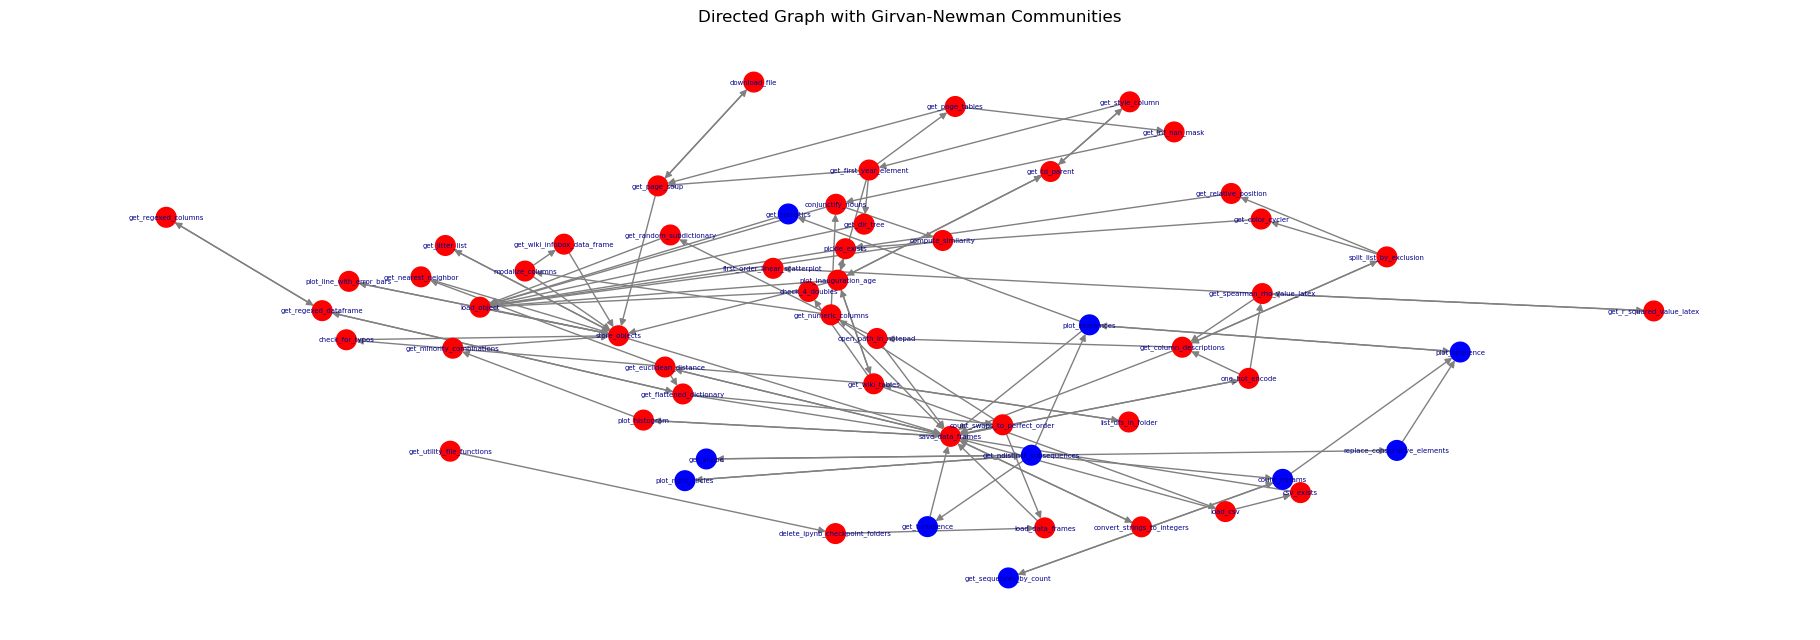

In [127]:

# Visualize the graph with nodes colored by their community
plt.figure(figsize=(18, 6))
pos = nx.spring_layout(directed_graph)  # Layout for better visualization
node_colors, community_list = get_girvan_newman_node_colors(directed_graph)
nx.draw(
    directed_graph,
    pos,
    edge_color="gray",
    font_color="darkblue",
    font_size=5,
    node_color=node_colors,  # Apply community colors
    node_size=200,
    with_labels=True,
)
plt.title("Directed Graph with Girvan-Newman Communities")
plt.show()

In [135]:

# Step 6: Print nodes in each community
for i, community_nodes in enumerate(community_list):
    print()
    print(f"Community {i}: {sorted(community_nodes)}")


Community 0: ['check_4_doubles', 'check_for_typos', 'compute_similarity', 'conjunctify_nouns', 'convert_strings_to_integers', 'count_swaps_to_perfect_order', 'csv_exists', 'delete_ipynb_checkpoint_folders', 'download_file', 'first_order_linear_scatterplot', 'get_color_cycler', 'get_column_descriptions', 'get_dir_tree', 'get_euclidean_distance', 'get_first_year_element', 'get_flattened_dictionary', 'get_inf_nan_mask', 'get_jitter_list', 'get_minority_combinations', 'get_nearest_neighbor', 'get_numeric_columns', 'get_page_soup', 'get_page_tables', 'get_r_squared_value_latex', 'get_random_subdictionary', 'get_regexed_columns', 'get_regexed_dataframe', 'get_relative_position', 'get_spearman_rho_value_latex', 'get_style_column', 'get_td_parent', 'get_utility_file_functions', 'get_wiki_infobox_data_frame', 'get_wiki_tables', 'list_dfs_in_folder', 'load_csv', 'load_data_frames', 'load_object', 'modalize_columns', 'one_hot_encode', 'open_path_in_notepad', 'pickle_exists', 'plot_histogram', 'p

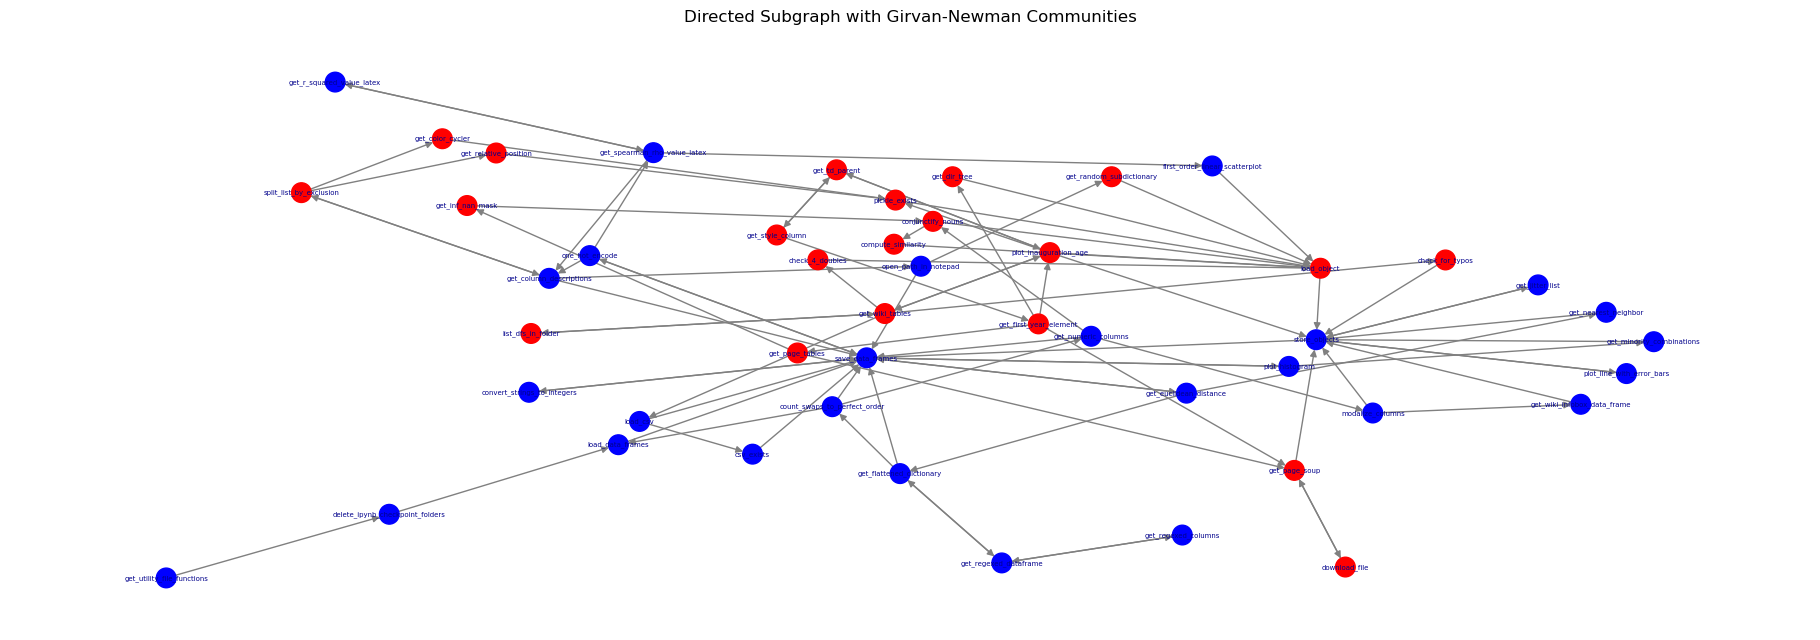

In [129]:

# Create the subgraph
subgraph_community0 = directed_graph.subgraph(community_list[0]).copy()

# Visualize the subgraph with nodes colored by their community
plt.figure(figsize=(18, 6))
pos = nx.spring_layout(subgraph_community0)  # Layout for better visualization
node_colors, community_list0 = get_girvan_newman_node_colors(subgraph_community0)
nx.draw(
    subgraph_community0,
    pos,
    edge_color="gray",
    font_color="darkblue",
    font_size=5,
    node_color=node_colors,  # Apply community colors
    node_size=200,
    with_labels=True,
)
plt.title("Directed Subgraph with Girvan-Newman Communities")
plt.show()

In [136]:

# Step 6: Print nodes in each community
for i, community_nodes in enumerate(community_list0):
    print()
    print(f"Community 0{i}: {sorted(community_nodes)}")


Community 00: ['check_4_doubles', 'check_for_typos', 'compute_similarity', 'conjunctify_nouns', 'download_file', 'get_color_cycler', 'get_dir_tree', 'get_first_year_element', 'get_inf_nan_mask', 'get_page_soup', 'get_page_tables', 'get_random_subdictionary', 'get_relative_position', 'get_style_column', 'get_td_parent', 'get_wiki_tables', 'list_dfs_in_folder', 'load_object', 'pickle_exists', 'plot_inauguration_age', 'split_list_by_exclusion']

Community 01: ['convert_strings_to_integers', 'count_swaps_to_perfect_order', 'csv_exists', 'delete_ipynb_checkpoint_folders', 'first_order_linear_scatterplot', 'get_column_descriptions', 'get_euclidean_distance', 'get_flattened_dictionary', 'get_jitter_list', 'get_minority_combinations', 'get_nearest_neighbor', 'get_numeric_columns', 'get_r_squared_value_latex', 'get_regexed_columns', 'get_regexed_dataframe', 'get_spearman_rho_value_latex', 'get_utility_file_functions', 'get_wiki_infobox_data_frame', 'load_csv', 'load_data_frames', 'modalize_col

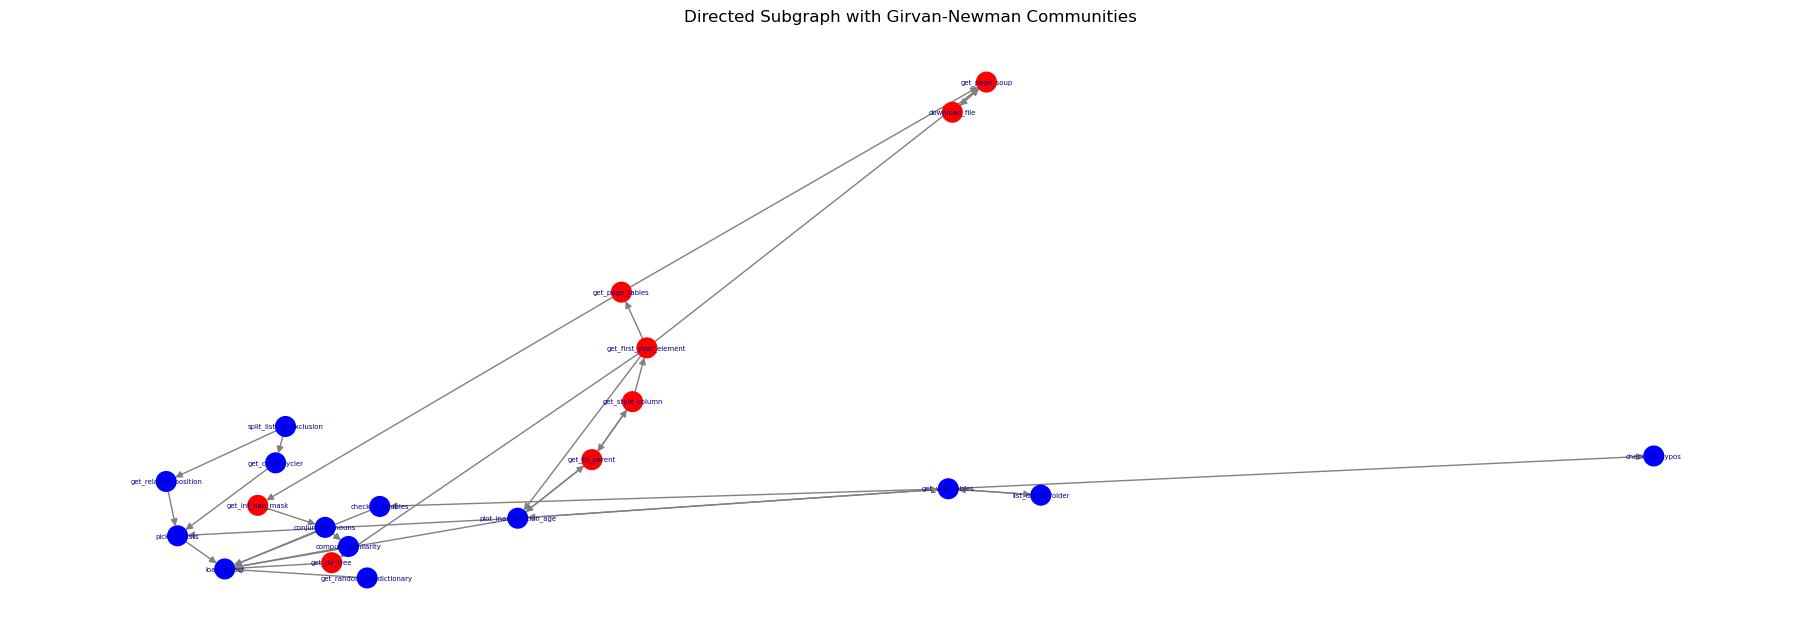

In [131]:

# Create the subgraph
subgraph_community00 = directed_graph.subgraph(community_list0[0]).copy()

# Visualize the subgraph with nodes colored by their community
plt.figure(figsize=(18, 6))
pos = nx.spring_layout(subgraph_community00)  # Layout for better visualization
node_colors, community_list00 = get_girvan_newman_node_colors(subgraph_community00)
nx.draw(
    subgraph_community00,
    pos,
    edge_color="gray",
    font_color="darkblue",
    font_size=5,
    node_color=node_colors,  # Apply community colors
    node_size=200,
    with_labels=True,
)
plt.title("Directed Subgraph with Girvan-Newman Communities")
plt.show()

In [137]:

# Step 6: Print nodes in each community
for i, community_nodes in enumerate(community_list00):
    print()
    print(f"Community 00{i}: {sorted(community_nodes)}")


Community 000: ['download_file', 'get_dir_tree', 'get_first_year_element', 'get_inf_nan_mask', 'get_page_soup', 'get_page_tables', 'get_style_column', 'get_td_parent']

Community 001: ['check_4_doubles', 'check_for_typos', 'compute_similarity', 'conjunctify_nouns', 'get_color_cycler', 'get_random_subdictionary', 'get_relative_position', 'get_wiki_tables', 'list_dfs_in_folder', 'load_object', 'pickle_exists', 'plot_inauguration_age', 'split_list_by_exclusion']


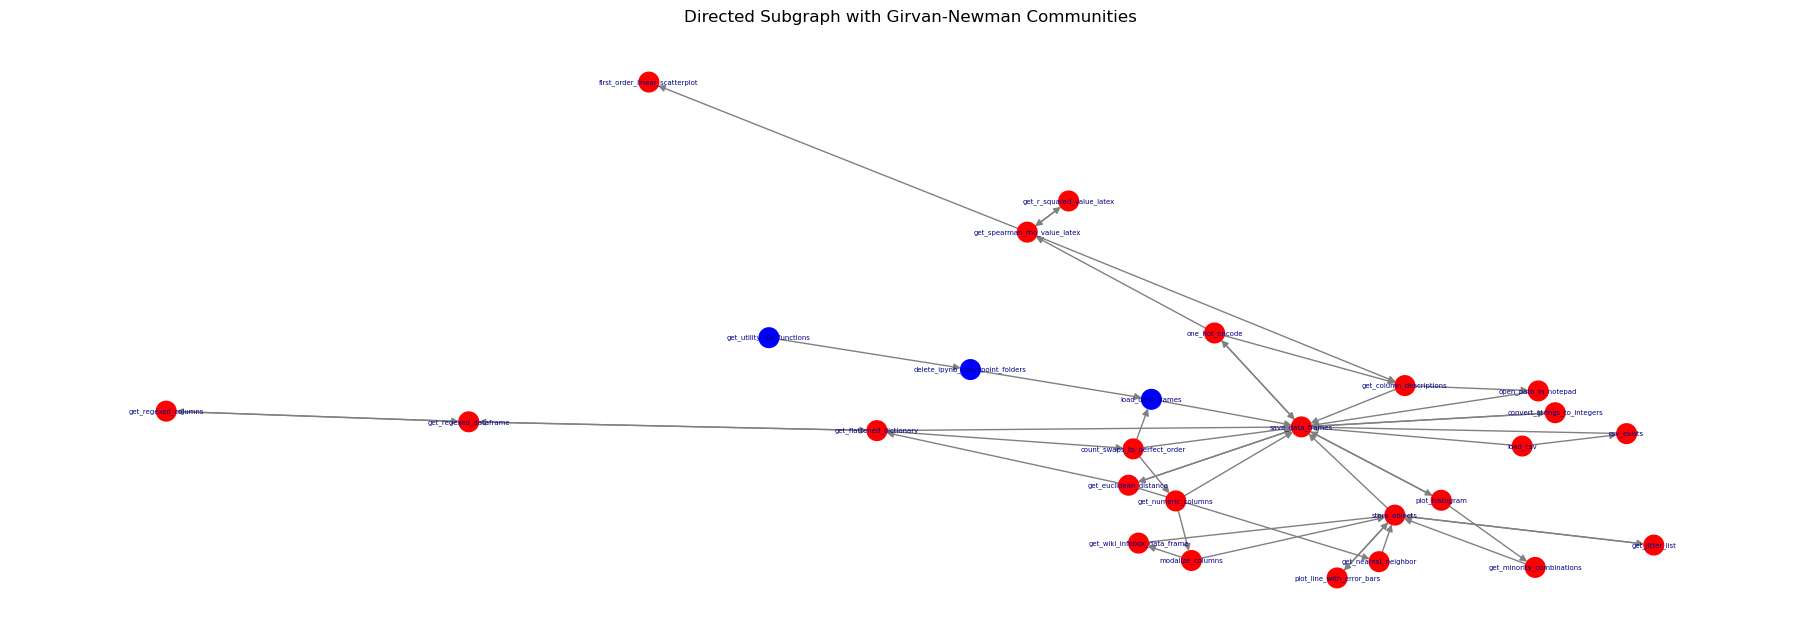

In [133]:

# Create the subgraph
subgraph_community01 = directed_graph.subgraph(community_list0[1]).copy()

# Visualize the subgraph with nodes colored by their community
plt.figure(figsize=(18, 6))
pos = nx.spring_layout(subgraph_community01)  # Layout for better visualization
node_colors, community_list01 = get_girvan_newman_node_colors(subgraph_community01)
nx.draw(
    subgraph_community01,
    pos,
    edge_color="gray",
    font_color="darkblue",
    font_size=5,
    node_color=node_colors,  # Apply community colors
    node_size=200,
    with_labels=True,
)
plt.title("Directed Subgraph with Girvan-Newman Communities")
plt.show()

In [138]:

# Step 6: Print nodes in each community
for i, community_nodes in enumerate(community_list01):
    print()
    print(f"Community 01{i}: {sorted(community_nodes)}")


Community 010: ['convert_strings_to_integers', 'count_swaps_to_perfect_order', 'csv_exists', 'first_order_linear_scatterplot', 'get_column_descriptions', 'get_euclidean_distance', 'get_flattened_dictionary', 'get_jitter_list', 'get_minority_combinations', 'get_nearest_neighbor', 'get_numeric_columns', 'get_r_squared_value_latex', 'get_regexed_columns', 'get_regexed_dataframe', 'get_spearman_rho_value_latex', 'get_wiki_infobox_data_frame', 'load_csv', 'modalize_columns', 'one_hot_encode', 'open_path_in_notepad', 'plot_histogram', 'plot_line_with_error_bars', 'save_data_frames', 'store_objects']

Community 011: ['delete_ipynb_checkpoint_folders', 'get_utility_file_functions', 'load_data_frames']


In [147]:

print(f"After removing the scratchpad-like notebook nodes ({nu.conjunctify_nouns(JUNK_NODES)}), I'm getting a more balance set of communities.")

After removing the scratchpad-like notebook nodes (Installs, OS Path Navigation, Scratchpad, and Attic), I'm getting a more balance set of communities.



This updated **three-generation breakdown** shows a much more balanced set of communities after removing the "scratchpad-like" nodes. The hierarchical structure provides a clearer picture of how the functions are related and can be grouped into more cohesive modules for refactoring.

---

### **Analysis of the Communities**

#### **First Generation**
- **Community 0**:
  - A large, general-purpose group with functions related to **data handling**, **utilities**, **file operations**, **visualization**, and **data analysis**.
  - Functions like `load_data_frames`, `get_page_tables`, `plot_histogram`, and `store_objects` suggest workflows related to **data processing and visualization**.
  - Other functions like `get_dir_tree`, `delete_ipynb_checkpoint_folders`, and `open_path_in_notepad` focus on **file and directory operations**.

- **Community 1**:
  - A small, focused group of functions related to **sequence analysis** and **statistical operations**.
  - Functions like `count_ngrams`, `get_ndistinct_subsequences`, `plot_sequences`, and `get_statistics` indicate this group is specialized for **sequence processing and visualization**.

**Implication**: The first generation splits the functions into:
1. A **general-purpose group** (Community 0) that covers most workflows.
2. A **specialized group** (Community 1) for sequence analysis.

---

#### **Second Generation**
- **Community 00**:
  - Functions related to **data extraction**, **validation**, and **utilities**:
    - **Data Extraction**: `get_page_soup`, `get_page_tables`, `get_wiki_tables`.
    - **Validation**: `check_4_doubles`, `check_for_typos`, `get_inf_nan_mask`.
    - **Utilities**: `download_file`, `get_dir_tree`, `split_list_by_exclusion`.
  - This group appears to focus on **data preparation workflows**.

- **Community 01**:
  - Functions related to **data manipulation**, **visualization**, and **statistical operations**:
    - **Data Wrangling**: `load_data_frames`, `save_data_frames`, `get_numeric_columns`, `modalize_columns`.
    - **Visualization**: `plot_histogram`, `plot_line_with_error_bars`.
    - **Statistical Tools**: `get_r_squared_value_latex`, `first_order_linear_scatterplot`, `one_hot_encode`.
  - This group appears to focus on **data analysis and visualization workflows**.

**Implication**: The second generation refines Community 0 into:
1. **Data preparation and validation** (Community 00).
2. **Data manipulation, analysis, and visualization** (Community 01).

---

#### **Third Generation**
- **Community 000**:
  - Functions related to **data extraction** and **utilities**:
    - `get_page_soup`, `get_page_tables`, `get_style_column`, `get_td_parent`.
    - **Utilities**: `download_file`, `get_dir_tree`, `get_first_year_element`.
  - This group focuses on **data preparation and extraction workflows**.

- **Community 001**:
  - Functions related to **data validation** and **utilities**:
    - **Validation**: `check_4_doubles`, `check_for_typos`, `get_inf_nan_mask`.
    - **Utilities**: `load_object`, `pickle_exists`, `list_dfs_in_folder`.
    - Includes some visualization (`plot_inauguration_age`) and utilities (`split_list_by_exclusion`).
  - This group focuses on **data validation workflows**.

- **Community 010**:
  - Functions related to **data manipulation**, **numerical computation**, and **visualization**:
    - **Data Wrangling**: `convert_strings_to_integers`, `modalize_columns`, `get_numeric_columns`.
    - **Visualization**: `plot_histogram`, `plot_line_with_error_bars`.
    - **Statistical Tools**: `get_r_squared_value_latex`, `first_order_linear_scatterplot`, `one_hot_encode`.
  - This group focuses on **data analysis and visualization workflows**.

- **Community 011**:
  - A small group related to **file operations and utility functions**:
    - `delete_ipynb_checkpoint_folders`, `get_utility_file_functions`, `load_data_frames`.
  - This group focuses on **file cleanup and basic data loading**.

**Implication**: The third generation provides a detailed breakdown of workflows:
1. **Data extraction and preparation** (Community 000).
2. **Data validation and utilities** (Community 001).
3. **Data analysis and visualization** (Community 010).
4. **File operations and general utilities** (Community 011).

---

### **Proposed Refactoring Based on Third Generation**

Using the third-generation breakdown, we can group the functions into cohesive modules. Here’s a proposed refactoring plan:

#### **Module 1: Data Preparation**
- **Functions**:
  - `download_file`, `get_dir_tree`, `get_first_year_element`, `get_inf_nan_mask`, `get_page_soup`, `get_page_tables`, `get_style_column`, `get_td_parent`.
- **Description**:
  - Handles **data extraction** and **preparation workflows**.
- **Suggested Module Name**:
  - `data_preparation.py`.

---

#### **Module 2: Data Validation**
- **Functions**:
  - `check_4_doubles`, `check_for_typos`, `compute_similarity`, `get_color_cycler`, `get_random_subdictionary`, `get_relative_position`, `get_wiki_tables`, `list_dfs_in_folder`, `load_object`, `pickle_exists`, `plot_inauguration_age`, `split_list_by_exclusion`.
- **Description**:
  - Focuses on **data validation** and **utility workflows**.
- **Suggested Module Name**:
  - `data_validation.py`.

---

#### **Module 3: Data Analysis and Visualization**
- **Functions**:
  - `convert_strings_to_integers`, `count_swaps_to_perfect_order`, `csv_exists`, `first_order_linear_scatterplot`, `get_column_descriptions`, `get_euclidean_distance`, `get_flattened_dictionary`, `get_jitter_list`, `get_minority_combinations`, `get_nearest_neighbor`, `get_numeric_columns`, `get_r_squared_value_latex`, `get_regexed_columns`, `get_regexed_dataframe`, `get_spearman_rho_value_latex`, `get_wiki_infobox_data_frame`, `load_csv`, `modalize_columns`, `one_hot_encode`, `open_path_in_notepad`, `plot_histogram`, `plot_line_with_error_bars`, `save_data_frames`, `store_objects`.
- **Description**:
  - Handles **data manipulation**, **numerical computations**, and **visualizations**.
- **Suggested Module Name**:
  - `data_analysis.py`.

---

#### **Module 4: File Operations**
- **Functions**:
  - `delete_ipynb_checkpoint_folders`, `get_utility_file_functions`, `load_data_frames`.
- **Description**:
  - Focuses on **file cleanup** and **basic file operations**.
- **Suggested Module Name**:
  - `file_operations.py`.

---

### **Steps to Refactor**

1. **Move Functions into New Modules**:
   - Create the four modules (`data_preparation.py`, `data_validation.py`, `data_analysis.py`, `file_operations.py`) and move the corresponding functions into them.

2. **Update Imports**:
   - Update all scripts and notebooks that use these functions to import them from their new modules.

3. **Test the Refactored Codebase**:
   - Ensure that all workflows in your notebooks still work correctly after the refactor.

4. **Iterate and Improve**:
   - After refactoring, monitor the usage patterns of the functions to refine the module structure further.

---

### **Benefits of the Refactoring**

1. **Cohesion**:
   - Functions are grouped by their purpose, making it easier to navigate the codebase.

2. **Scalability**:
   - New functions can be easily added to the appropriate modules without cluttering the codebase.

3. **Maintainability**:
   - Modular design simplifies debugging, testing, and updating the codebase.

In [156]:

# Define the folder where the original file is located
original_file = "notebook_utils.py"
output_folder = osp.abspath(osp.join(os.pardir, os.pardir, 'share'))  # Save new modules in the same folder as the original file
original_path = osp.join(output_folder, original_file)
print(original_path)

C:\Users\daveb\OneDrive\Documents\GitHub\share\notebook_utils.py


In [150]:

# Define categories for the functions
function_categories = {
    "data_preparation": community_list00[0],
    "data_validation": community_list00[1],
    "data_analysis": community_list01[0],
    "file_operations": community_list01[1]
}

In [151]:

# Function to parse the file and extract functions from the class
def extract_functions_by_category(file_path, function_categories, output_folder):
    # Read the source code
    with open(file_path, "r") as f:
        source_code = f.read()
    
    # Parse the source code into an AST
    tree = ast.parse(source_code)
    
    # Find the class definition
    class_def = None
    for node in tree.body:
        if isinstance(node, ast.ClassDef):
            class_def = node
            break
    
    if class_def is None:
        raise ValueError("No class definition found in the file.")
    
    # Extract functions from the class
    categorized_functions = {category: [] for category in function_categories}
    other_functions = []  # Functions that don't match any category
    
    for node in class_def.body:
        if isinstance(node, ast.FunctionDef):
            function_name = node.name
            # Check which category this function belongs to
            found_category = False
            for category, functions in function_categories.items():
                if function_name in functions:
                    categorized_functions[category].append(node)
                    found_category = True
                    break
            if not found_category:
                other_functions.append(node)
    
    # Write functions to their respective modules
    for category, functions in categorized_functions.items():
        if functions:
            save_to_module(category, functions, output_folder)
    
    # Optionally handle uncategorized functions
    if other_functions:
        save_to_module("uncategorized", other_functions, output_folder)

In [152]:

# Function to save functions to a Python module
def save_to_module(module_name, functions, output_folder):
    # Create the class name from the module name
    class_name = ''.join(word.capitalize() for word in module_name.split('_'))  # e.g., "data_analysis" -> "DataAnalysis"
    
    # Determine the file path for the module
    module_path = os.path.join(output_folder, f"{module_name}.py")
    
    with open(module_path, "w") as f:
        # Write a header comment
        f.write("# Auto-generated module\n\n")
        
        # Write the class definition
        f.write(f"class {class_name}:\n")
        
        # Handle the case where there are no functions
        if not functions:
            f.write("    pass\n\n")
        
        # Write each function inside the class
        for func in functions:
            # Indent the function code to place it inside the class
            func_code = ast.unparse(func)  # Requires Python 3.9+
            indented_code = indent_code(func_code, spaces=4)  # Indent by 4 spaces
            f.write(indented_code)
            f.write("\n\n")
    
    print(f"Saved {len(functions)} functions to {module_path} in class {class_name}")

In [153]:

def indent_code(code, spaces=4):
    """Helper function to indent code by the specified number of spaces."""
    indentation = ' ' * spaces
    return '\n'.join(indentation + line if line.strip() else line for line in code.splitlines())

In [157]:

# Run the extraction process
extract_functions_by_category(original_path, function_categories, output_folder)

Saved 8 functions to C:\Users\daveb\OneDrive\Documents\GitHub\share\data_preparation.py in class DataPreparation
Saved 13 functions to C:\Users\daveb\OneDrive\Documents\GitHub\share\data_validation.py in class DataValidation
Saved 24 functions to C:\Users\daveb\OneDrive\Documents\GitHub\share\data_analysis.py in class DataAnalysis
Saved 3 functions to C:\Users\daveb\OneDrive\Documents\GitHub\share\file_operations.py in class FileOperations
Saved 55 functions to C:\Users\daveb\OneDrive\Documents\GitHub\share\uncategorized.py in class Uncategorized


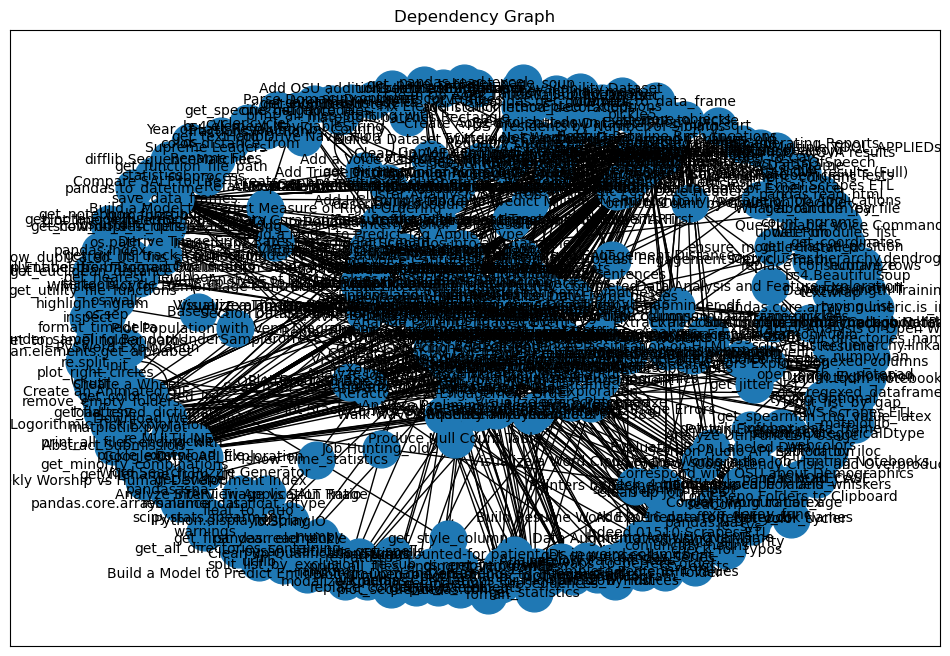

In [148]:

visualize_graph(dependency_graph)